# Support Vector Machine Predictive Model for EDTA QC Evaluation: Part 2 – Model Optimization

We will build a **Support Vector Machine** (SVM) classifier using **scikit-learn**. Two datasets (training and unknown) are used for modeling. The training dataset contains experimental data from healthy donors (described in the current manuscript: https://neco.cz). The unknown dataset contains experimental samples from healthy donors and colorectal carcinoma donors (Slyskova et al. 2015: https://pubmed.ncbi.nlm.nih.gov/24585457/). The SVM will predict blood sample quality from EDTA tubes (normal or altered gene expression) for downstream gene expression analysis.

Contents:
- **Module Imports**

- **Prediction on Unseen Data and Optimalization of the Decision Boundary**
    - Importing data
    - Importing joblib libraries
    - Preprocessing data
    - Adjusting the decision threshold
    - Evaluation and visualization of the decision boundary
    - Analyzing threshold ranges without changing FNR and FPR
    - Determining FNR and threshold ranges for reliable predictions
    - Selecting the decision threshold based on FNR
    - Built-in data and final outcome from EDTA_QC testing


----
----

#### Module Imports

In [21]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from pathlib import Path

In [22]:
# ── Setup paths relative to project root ──
cwd = Path().cwd()
ROOT = cwd
while not (ROOT / "README.md").exists():
    ROOT = ROOT.parent
  
DATA_DIR   = ROOT / "data"
MODELS_DIR = ROOT / "models"

TRAIN_DATA_PATH   = DATA_DIR / "train_data.csv"
TEST_DATA_PATH    = DATA_DIR / "test_data.csv"
EXAMPLE_DATA_PATH = DATA_DIR / "example_new_samples.csv"

PIPELINE_PATH = MODELS_DIR / "final_pipeline_prob.joblib"
# ── End setup ──

# ── Notebook outputs folder ──
NB_OUTPUT = ROOT / "notebooks" / "outputs_from_notebooks"
NB_OUTPUT.mkdir(parents=True, exist_ok=True)
# ── End notebook outputs setup ──

----
----

#### **Prediction on Unseen Data and Optimalization of the Decision Boundary**

In this section, we will test the SVM model on unseen data and optimize the decision boundary.  

#### Task 1: Importing data

In [23]:
train_df = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
test_df = pd.read_csv(TEST_DATA_PATH, index_col=0)
unknown_df = pd.read_csv(EXAMPLE_DATA_PATH, index_col=0)

In [24]:
if "sample" in train_df.columns:
    train_samples = train_df["sample"]
    train_df = train_df.drop(columns="sample")
else:
    train_samples = train_df.index.astype(str)
if "sample" in test_df.columns:
    test_samples = test_df["sample"]
    test_df = test_df.drop(columns="sample")
else:
    test_samples = test_df.index.astype(str)
if "sample" in unknown_df.columns:
    unknown_samples = unknown_df["sample"]
    unknown_df = unknown_df.drop(columns="sample")
else:
    unknown_samples = unknown_df.index.astype(str)

----

#### Task 2: Importing joblib libraries

In [25]:
pipeline = joblib.load(PIPELINE_PATH)

model  = pipeline.named_steps['model']
scaler = pipeline.named_steps['scaler']
pca    = pipeline.named_steps['pca']

----

#### Task 3: Preprocessing data

In [26]:
# Define feature matrix (X) and target vector (y) for model fitting
feature_cols = scaler.feature_names_in_
X_test       = test_df[feature_cols]

y_train = train_df["groups"].astype(int)
X_train = train_df[feature_cols]

y_test  = test_df["groups"].astype(int)
X_test  = test_df[feature_cols]

# Unknown_df lacks group labels
X_unknown = unknown_df[feature_cols]

# Scale the feature data
X_train_scaled   = scaler.transform(X_train)
X_test_scaled    = scaler.transform(X_test)
X_unknown_scaled = scaler.transform(X_unknown)

# Apply PCA transformation
X_train_pca   = pca.transform(X_train_scaled)
X_test_pca    = pca.transform(X_test_scaled)
X_unknown_pca = pca.transform(X_unknown_scaled)

# Predict labels for unknown data using the threshold = 0
y_unknown_pred = model.predict(X_unknown_pca)


----

#### Task 4: Adjusting the decision threshold

In [27]:
# Decision scores computation
scores_unk   = model.decision_function(X_unknown_pca)
scores_train = model.decision_function(X_train_pca)
scores_test  = model.decision_function(X_test_pca)

# Generating initial predictions with default threshold
y_unk_orig   = (scores_unk > 0).astype(int)
y_train_orig   = (scores_train   > 0).astype(int)
y_test_orig  = (scores_test  > 0).astype(int)


----

#### Task 5: Evaluation and visualization of the decision boundary

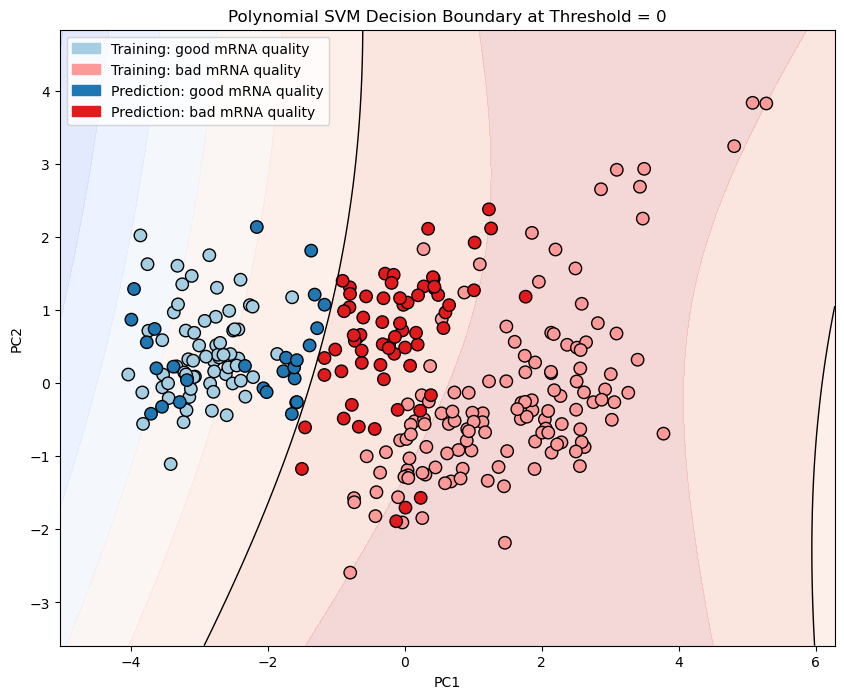

In [28]:
# Generate meshgrid and decision surface
plt.figure(figsize=(10,8))
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.decision_function(grid).reshape(xx.shape)

# Define custom colormaps
cmap_train = mcolors.ListedColormap(['#fb9a99', '#a6cee3'])  # Light colors for train data
cmap_unknown =  mcolors.ListedColormap(['#e31a1c', '#1f78b4'])

plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm_r)# Decision boundary
plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=1) #levels are responsible for the threshold

# Scatter plot: training data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
    c=y_train, cmap=cmap_train, edgecolors='k', s=80, label='Train')

# Scatter plot: unknown data
plt.scatter(X_unknown_pca[:, 0], X_unknown_pca[:, 1],
    c=y_unknown_pred, cmap=cmap_unknown, edgecolors='k', s=80, label='Unknown')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Polynomial SVM Decision Boundary at Threshold = 0')

# Create legend
patch0_train = mpatches.Patch(color='#a6cee3', label='Training: good mRNA quality')
patch1_train = mpatches.Patch(color='#fb9a99', label='Training: bad mRNA quality')
patch0_test = mpatches.Patch(color='#1f78b4', label='Prediction: good mRNA quality')
patch1_test = mpatches.Patch(color='#e31a1c', label='Prediction: bad mRNA quality')

plt.legend(handles=[patch0_train, patch1_train, patch0_test, patch1_test], loc='upper left')

plt.show()

In [29]:
# Key hyperparameters
print("\n=== Key hyperparameters ===")
print(f"Kernel: {model.kernel}")
print(f"Degree: {model.degree}")
print(f"C:      {model.C}")
print(f"Gamma:  {model.gamma}")
print(f"Coef0:  {model.coef0}")
print(f"Total support vectors: {model.support_vectors_.shape[0]}")

print("\n=== Threshold-dependent parameters ===")
print(f"Original threshold: 0")
pos_orig = np.sum(y_unk_orig == 1)
neg_orig = np.sum(y_unk_orig == 0)
print(f"\nNumber of samples classified as OK (1) at threshold 0:  {pos_orig}")
print(f"Number of samples classified as altered (0) at threshold 0: {neg_orig}")



=== Key hyperparameters ===
Kernel: poly
Degree: 2
C:      0.1
Gamma:  0.1
Coef0:  0.5
Total support vectors: 40

=== Threshold-dependent parameters ===
Original threshold: 0

Number of samples classified as OK (1) at threshold 0:  26
Number of samples classified as altered (0) at threshold 0: 66


----

#### Task 6: Analyzing threshold ranges without changing FNR and FPR

In [30]:
# Test data score range
max_neg_score_test = scores_test[y_test == 0].max()
min_pos_score_test = scores_test[y_test == 1].min()

# Threshold range without altering test predictions, FNR, or FPR
print(f"↔️ Threshold range preserving test predictions, FNR, and FPR "
      f"({max_neg_score_test:.4f}, {min_pos_score_test:.4f}) ")


↔️ Threshold range preserving test predictions, FNR, and FPR (-0.5560, 0.2159) 


----

#### Task 7: Determining FNR and threshold ranges for reliable predictions

In [31]:
# FNR values to test
fnr_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


FNR: 0%
Calculated threshold based on test data for 0% FNR: -0.5560


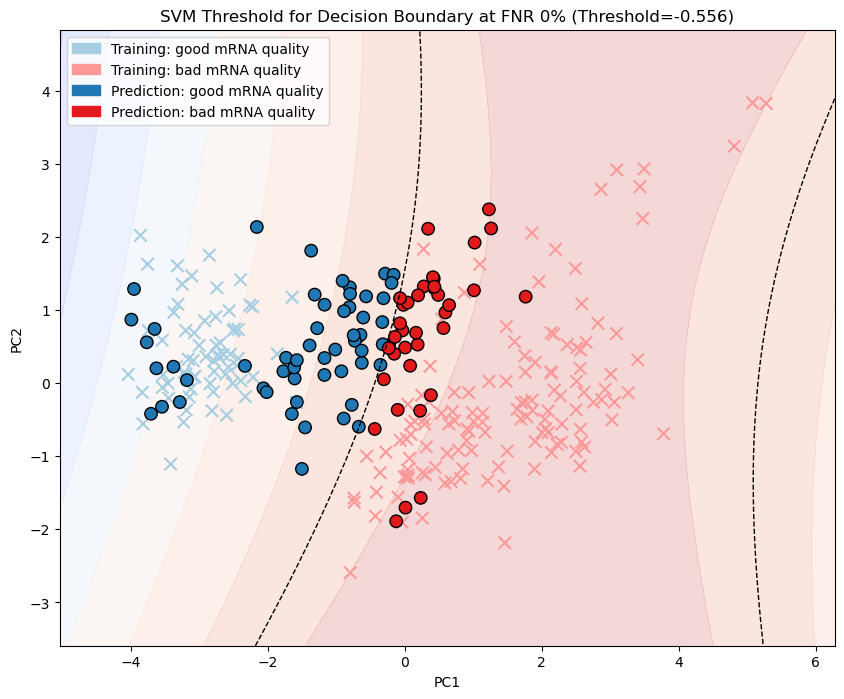

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 14
Number of samples classified as altered (0): 9
Number of samples with changed classification compared to the threshold 0: 0
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 3, EDTA T24 4, EDTA T24 5, EDTA T24 7

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         9
     Class 1       1.00      1.00      1.00        14

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

An AUC of 1.0 suggests the model can reliably distinguish between the tw

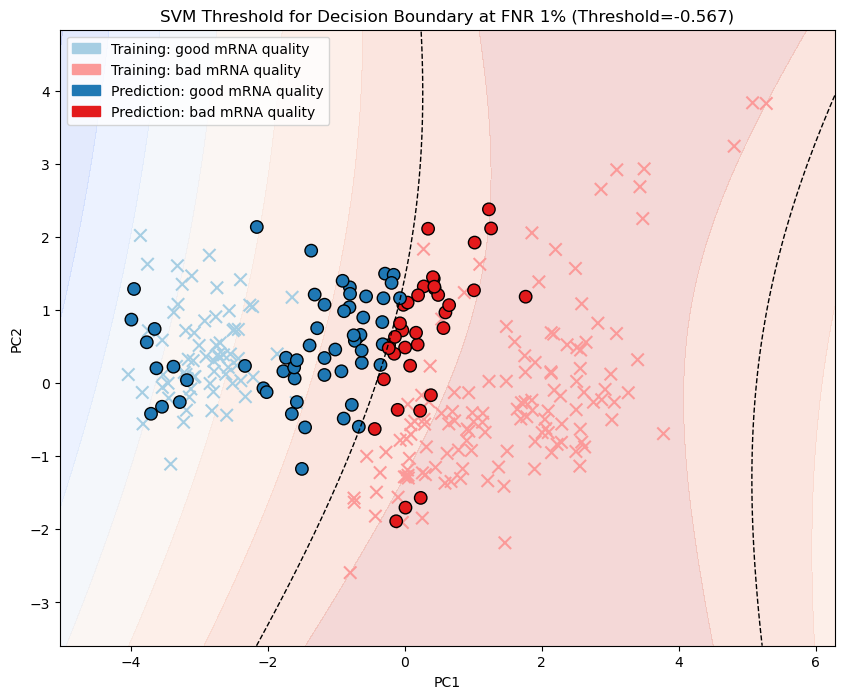

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

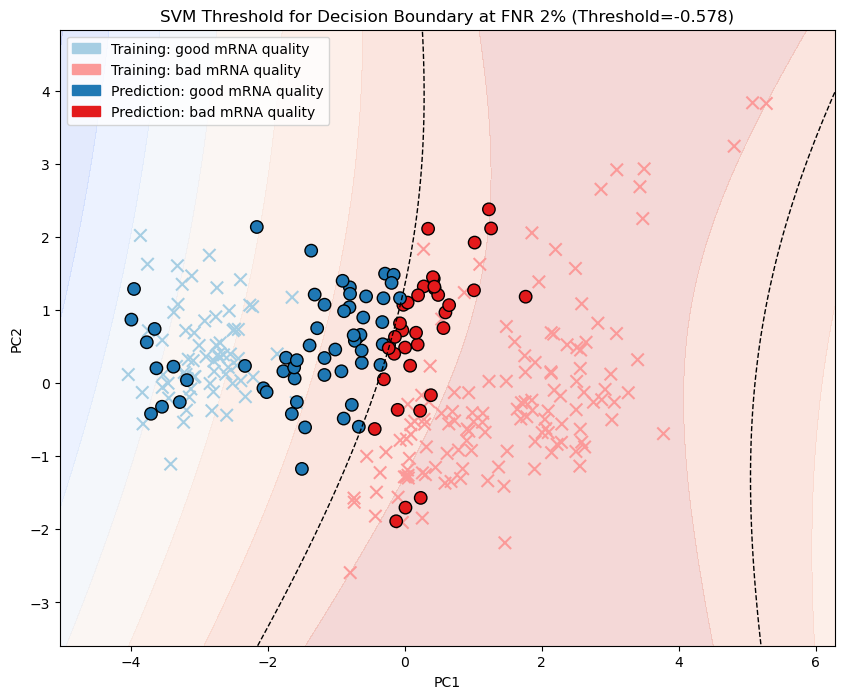

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

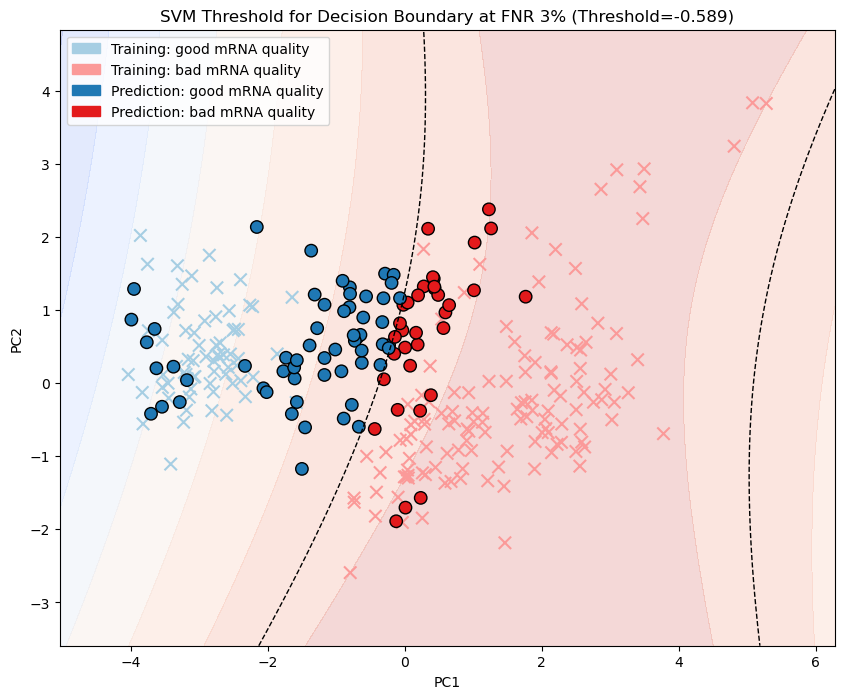

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

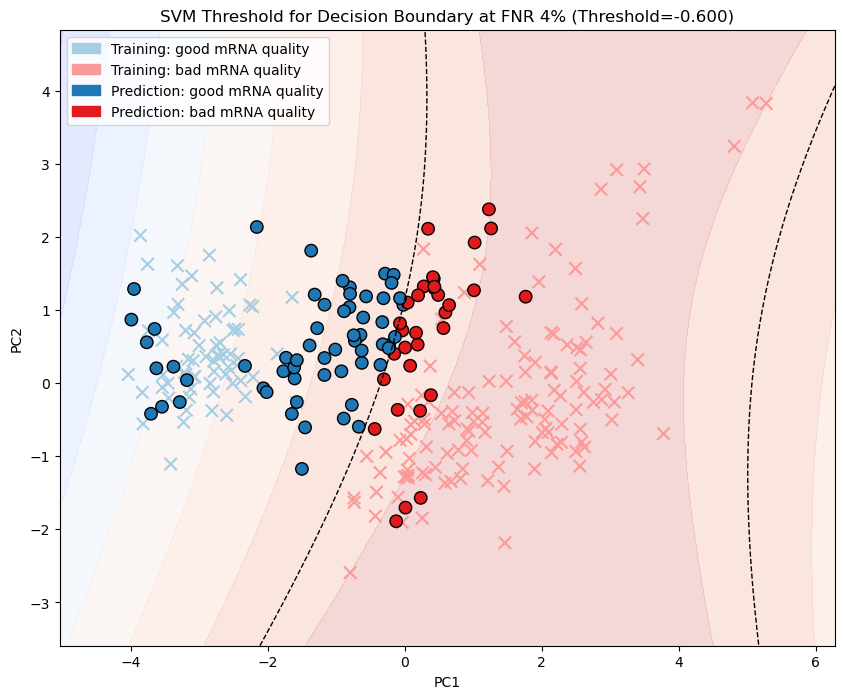

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

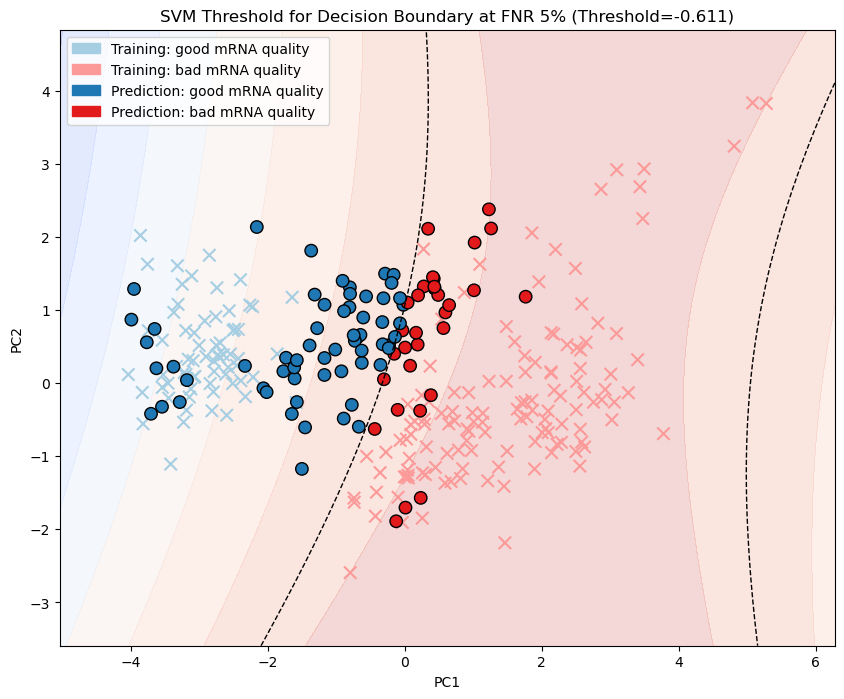

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

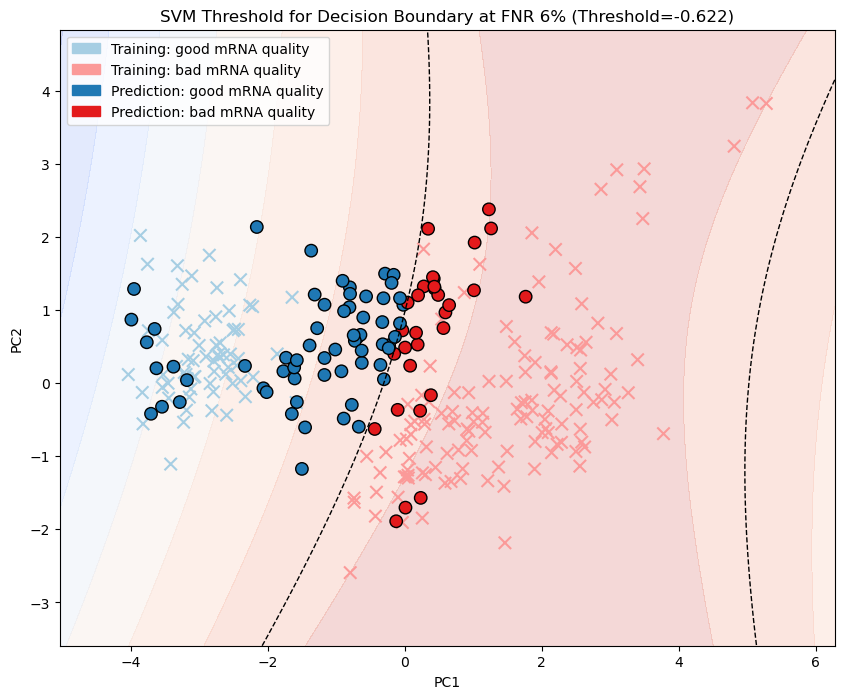

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

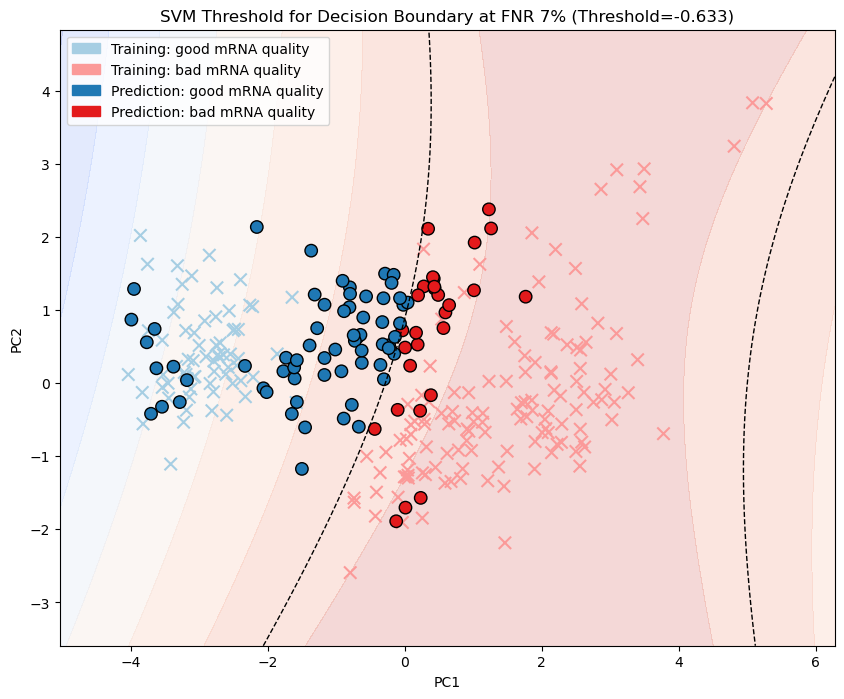

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

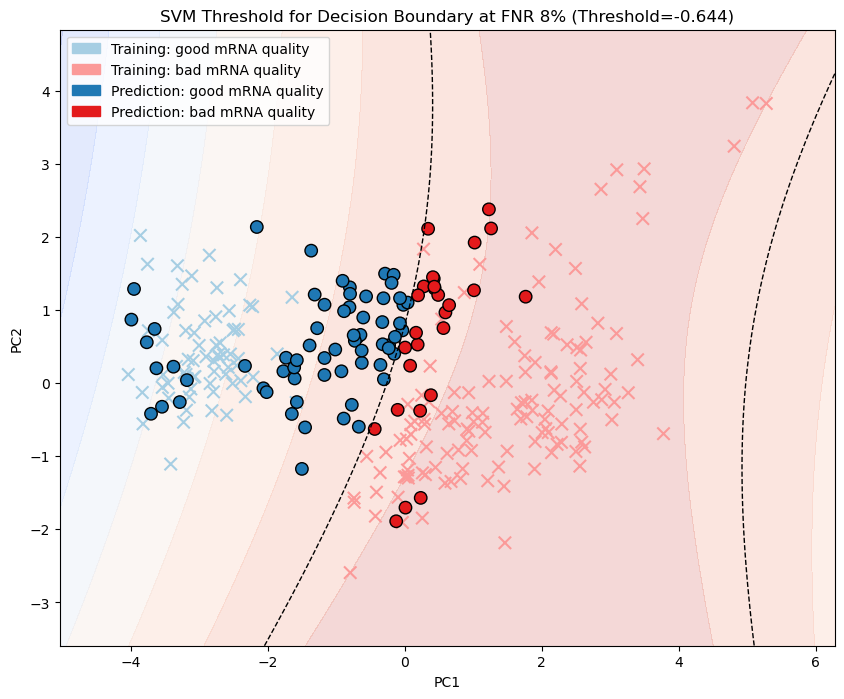

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

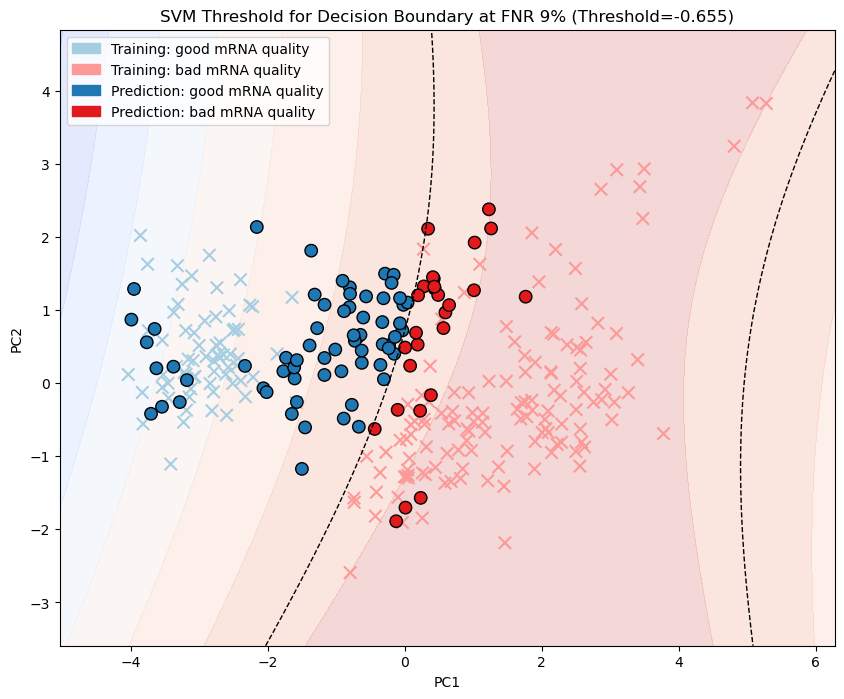

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

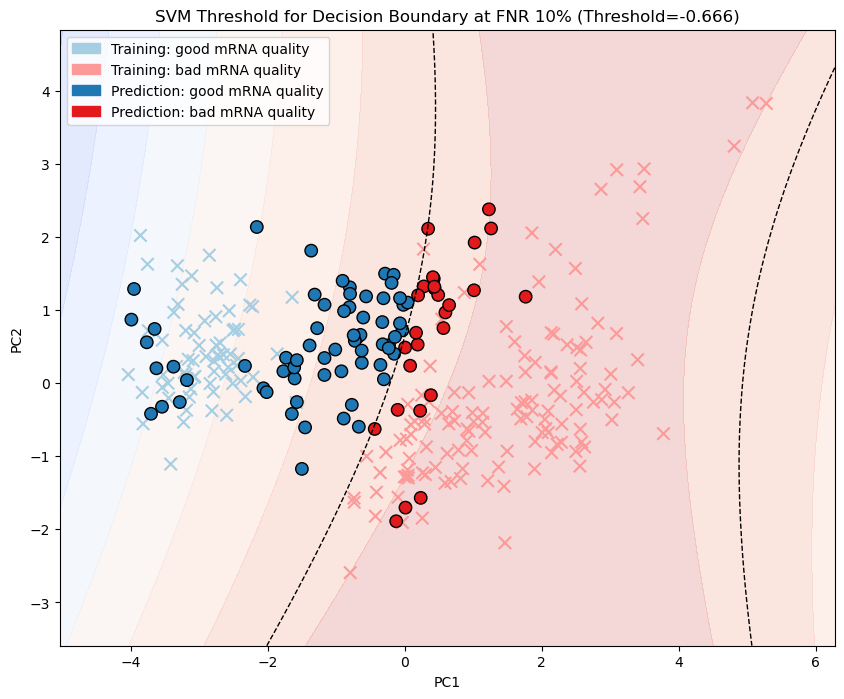

----------------------------------------

[Original Test Data]
Number of samples classified as OK (1): 15
Number of samples classified as altered (0): 8
Number of samples with changed classification compared to the threshold 0: 1
Samples predicted as OK:
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA T6 1, EDTA T6 2, EDTA T6 3, EDTA T6 4

Samples predicted as altered:
EDTA 8759-24, EDTA 8760-24, EDTA 8762-24, EDTA T24 1, EDTA T24 2, EDTA T24 4, EDTA T24 5, EDTA T24 7

Samples with changed classification for test set:
EDTA T24 3

🔹 Classification report for test set:
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94         9
     Class 1       0.93      1.00      0.97        14

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

An AUC of 

In [ ]:
for fnr in fnr_list:
    print(f"\n{'='*40}\nFNR: {fnr}%")

    # Calculating threshold from test scores for poor-quality samples
    bad_scores_test = scores_test[y_test == 0]
    threshold_dynamic = np.percentile(bad_scores_test, 100 - fnr)
    print(f"Calculated threshold based on test data for {fnr}% FNR: {threshold_dynamic:.4f}")

    # Updating predictions based on dynamic threshold
    y_train_adj = (scores_train > threshold_dynamic).astype(int)
    y_test_adj = (scores_test > threshold_dynamic).astype(int)
    y_unk_adj = (scores_unk > threshold_dynamic).astype(int)

    # Plotting decision boundary at adjusted threshold
    plt.figure(figsize=(10, 8))
    plt.title(f"SVM Threshold for Decision Boundary at FNR {fnr}% (Threshold={threshold_dynamic:.3f})")
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.decision_function(grid).reshape(xx.shape)

    #  Define custom colormaps for plotting
    cmap_train = mcolors.ListedColormap(['#fb9a99', '#a6cee3'])  # Light colors for train data
    cmap_unknown =  mcolors.ListedColormap(['#e31a1c', '#1f78b4'])

    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm_r) # Decision boundary
    plt.contour(xx, yy, Z, levels=[threshold_dynamic], colors='k', linewidths=1) #levels are responsible for the threshold

    # Scatter plot: training data
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
    c=y_train, cmap=cmap_train, marker='x', s=80, label='Train')

    # Scatter plot: unknown data
    plt.scatter(X_unknown_pca[:, 0], X_unknown_pca[:, 1],
    c=y_unk_adj, cmap=cmap_unknown, edgecolors='k', s=80, label='Unknown')

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    # Legend patches
    patch0_train = mpatches.Patch(color='#a6cee3', label='Training: good mRNA quality')
    patch1_train = mpatches.Patch(color='#fb9a99', label='Training: bad mRNA quality')
    patch0_unknown = mpatches.Patch(color='#1f78b4', label='Prediction: good mRNA quality')
    patch1_unknown = mpatches.Patch(color='#e31a1c', label='Prediction: bad mRNA quality')

    plt.legend(handles=[patch0_train, patch1_train, patch0_unknown, patch1_unknown], loc='upper left')
    plt.show()


    # TEST data
    good_test_idx = np.where(y_test_adj == 1)[0]
    bad_test_idx = np.where(y_test_adj == 0)[0]
    changed_test_idx = np.where(y_test_adj != y_test_orig)[0]

    print("-"*40)
    print("\n[Original Test Data]")
    print(f"Number of samples classified as OK (1): {len(good_test_idx)}")
    print(f"Number of samples classified as altered (0): {len(bad_test_idx)}")
    print(f"Number of samples with changed classification compared to the threshold 0: {len(changed_test_idx)}")

    if isinstance(test_samples, pd.Series):
        good_test_samples = test_samples.iloc[good_test_idx].tolist()
        bad_test_samples = test_samples.iloc[bad_test_idx].tolist()
        changed_test_samples = test_samples.iloc[changed_test_idx].tolist()
    else:
        good_test_samples = test_samples[good_test_idx].tolist()
        bad_test_samples = test_samples[bad_test_idx].tolist()
        changed_test_samples = test_samples[changed_test_idx].tolist()

    print("Samples predicted as OK:")
    print(", ".join(map(str, good_test_samples)) if good_test_samples else "None samples")
    print("\nSamples predicted as altered:")
    print(", ".join(map(str, bad_test_samples)) if bad_test_samples else "None samples")

    if changed_test_samples:
        print("\nSamples with changed classification for test set:")
        print(", ".join(map(str, changed_test_samples)))

    print("\n🔹 Classification report for test set:")
    print(classification_report(y_test, y_test_adj, target_names=["Class 0", "Class 1"]))
    
    y_scores = model.predict_proba(X_test_pca)[:, 1]
    fpr_poly, tpr_poly, thresholds = roc_curve(y_test, y_scores)
    roc_auc_poly = auc(fpr_poly, tpr_poly)
    print(f'An AUC of {roc_auc_poly:.1f} suggests the model can reliably distinguish between the two classes, demonstrating strong performance.')

    # TRAIN data (change control)
    print("-"*40)
    print("\n[Original Train Data - Change Control]")
    changed_train_idx = np.where(y_train_adj != y_train_orig)[0]
    if len(changed_train_idx) > 0:
        print(f"⚠️ {len(changed_train_idx)} training samples changed classification compared to original settings!")
        if isinstance(train_samples, pd.Series):
            changed_train_samples = train_samples.iloc[changed_train_idx].tolist()
        else:
            changed_train_samples = train_samples[changed_train_idx].tolist()
        print("Changed samples:")
        print(", ".join(map(str, changed_train_samples)))
    else:
        print("No classification changes compared to original settings.")
    
    # UNKNOWN data (we are interested in)
    good_unk_idx = np.where(y_unk_adj == 1)[0]
    bad_unk_idx = np.where(y_unk_adj == 0)[0]
    changed_unk_idx = np.where(y_unk_adj != y_unk_orig)[0]

    print("-"*40)
    print("\n[Unknown Data]")
    print(f"Number of samples classified as OK (1): {len(good_unk_idx)}")
    print(f"Number of samples classified as altered (0): {len(bad_unk_idx)}")
    print(f"Number of samples with changed classification compared to the threshold 0: {len(changed_unk_idx)}")

    if len(changed_unk_idx) > 0:
        if isinstance(unknown_samples, pd.Series):
            changed_unk_samples = unknown_samples.iloc[changed_unk_idx].tolist()
        else:
            changed_unk_samples = unknown_samples[changed_unk_idx].tolist()    

    # Save predictions to CSV in the notebook’s output folder
    output_df = pd.DataFrame({
        'sample': unknown_samples,
        f'predicted_class_FNR{fnr}': y_unk_adj
    })
    filename = NB_OUTPUT / f"unknown_predictions_FNR{fnr}.csv"
    output_df.to_csv(filename, index=False)
    print(f"✅ Unknown data exported to: {filename}")

   

----

#### Task 8: Selecting the decision threshold based on FNR

ℹ️ Rationale for Adjusting the False Negative Rate (FNR) in the Application

Adjusting the FNR shifts the decision threshold toward the OK class, allowing a small fraction of samples with borderline altered gene expression to be classified as good quality samples. Because our altered-expression criteria are very stringent, these marginal cases pose minimal risk.

FNR = 0%**: The strictest setting. The decision threshold sits at the extreme edge of the altered distribution, so all other samples, even borderline cases, are classified as OK.

Maximum FNR = 9%: The highest FNR that still maintains 100% specificity on the training set (i.e., no altered training sample is misclassified).



Our unknown samples were of good quality and were mixed with test samples of poorer quality. Therefore, our hypothesis is to maximize the number of “good” samples correctly identified while ensuring “poor” samples are accurately detected. Based on this, the optimal FNR threshold for our unknown samples was set to 5% (build-in example).



----

#### Task 9: Built-in data and final outcome from EDTA_QC testing

We all know that even the best-intentioned EDTA blood draws can sit too long in the tube and quietly distort mRNA levels. Described EDTA QC tool lets you catch those hidden QC failures before they sneak into your biological analyses. To illustrate its use, we applied our EDTA QC application to an already published dataset. Our built-in example uses the data from Slyskova et al. (2015).

In that study, mRNA expression was measured in four cohorts: healthy volunteers, pre-operative colorectal carcinoma patients, early post-operative patients, and six-month survivors—using a rigorously validated cancer-marker panel. Those markers successfully grouped most samples into two clusters (diseased vs. recovered/healthy), but a few “strayed” into the wrong cluster. Unfortunately, those outliers all had sufficiently high RIN scores, so standard RNA-integrity filters provided no reason to exclude them. That’s where our application comes in.

We developed an EDTA QC marker panel capable of distinguishing “good” quality samples from those whose mRNA expression had been altered by suboptimal handling.

In Figure 1, you can see a PCA plot showing two clusters corresponding to the four patient cohorts; however, some samples overlap, making the separation somewhat fuzzy. This is the PCA plot before EDTA QC filtering.

![Before cleaning](before.jpg)  

In Figure 2, the same PCA plot is shown after EDTA QC flagged and removed suspect samples. The false negative rate was set to 5%. Under this condition, one-third of the samples were excluded because they were impaired during EDTA tube handling.

![After cleaning](after.jpg)

Conclusion
When the EDTA QC markers were used to clean this dataset:

    The cancer-marker panel achieved even higher specificity than originally reported (by removing potential bias introduced by EDTA tubes).

    It became clear why dedicated tubes and strict handling are essential for maintaining stable gene expression.

----
----

Go to application via terminal: streamlit run src/app.py